## 신기술 R&D 논문 탐색 자동화를 통한 미래기술 예측 모듈 개발(PoC)

![](./images/concep1.png)


In [1]:
import os
import pandas as pd
import pandas_profiling
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from gensim.models.word2vec import Word2Vec
import nltk
import time
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

from eunjeon import Mecab

# %appdata%\nltk_data\corpora\stopwords
# korean 파일을 생성하여 복사함
from nltk.corpus import stopwords 
nltk.download('stopwords')

np.random.seed(42)

mecab = Mecab('C://mecab//mecabrc')

# 한글깨짐 방지를 위한 글꼴 설정
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\milly\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


### 1. 통합된 원본 데이터 파일을 읽어온다

In [2]:
# RPA로부터 수집된 "자동차" 관련 50568개의 논문 데이터 셋을 로드함

ROOT_DIR = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
dataset = pd.read_csv(os.path.join(ROOT_DIR, "dataset/articles.csv"))
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50568 entries, 0 to 50567
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   제목                              50568 non-null  object 
 1   저자                              50568 non-null  object 
 2   발행기관                            50568 non-null  object 
 3   학술지명                            50568 non-null  object 
 4   권호사항                            50568 non-null  object 
 5   발행연도                            50568 non-null  int64  
 6   작성언어                            50568 non-null  object 
 7   주제어                             26933 non-null  object 
 8   KDC                             11761 non-null  float64
 9   등재정보                            13083 non-null  object 
 10  자료형태                            50568 non-null  object 
 11  발행기관 URL                        22715 non-null  object 
 12  수록면                             

In [3]:
dataset.head()

제목  \
0                       전기 이륜자동차 분류기준 현황 : 자동차관리법 중심   
1             자동차 사회의 환경과 에너지 문제 = 자동차 엔진 기술의 역사적 동향   
2  수소 연료전지 자동차의 충돌 및 화재안전성 관련 연구동향 = Trends on Cr...   
3  차세대 자동차 개발의 Plastic Hood 설계 및 CAE해석 = Plastic ...   
4  자동차 산업의 역사와 급변하는 기술에 대응한 교육의 바람직한 방향에 관한 연구 = ...   

                                                  저자      발행기관  \
0                                                정윤재  한국자동차공학회   
1                                  김영길(Yong Kil Kim)  한국자동차공학회   
2  임재문(Jae Moon Lim),장형진(Hyung Jin Chang),김규현(Gyu...  한국자동차공학회   
3  황태원(Taewon Hwang),최치훈(Chihoon Choi),박상선(Sangsu...  한국자동차공학회   
4                                황경수(Kyungsoo Whang)  한국자동차공학회   

                     학술지명                     권호사항  발행연도    작성언어  \
0       한국자동차공학회 Workshop   Vol.2011No.9[2011]\r\n  2011  Korean   
1     한국자동차공학회 학술대회 및 전시회  Vol.2014No.11[2014]\r\n  2014  Korean   
2  한국자동차공학회 춘 추계 학술대회 논문집      Vol.-No.-[2008]\r\n  2008  Korean   
3  한국자동차공학회 춘 추계 학술대회 논문집      Vol.-No.-[2006]\r\n  2006  Korean   
4       한국자동차공학회 Workshop   Vol.2001No.-[2001]\r\n  2001  Korean   

                                                 주제어    KDC 등재정보  ...  \
0                                                NaN  556.0  NaN  ...   
1  Internal Combustion Engine(내연기관),Energy (에너지),...    NaN  NaN  ...   
2  Hydrogen Fuel Cell Vehicle(수소 연료전지 자동차),Crash ...    NaN  NaN  ...   
3  HOOD(본넷트),Distance(이동량),LS-DYNA(구조해석),MOLDFLOW...    NaN  NaN  ...   
4                                                NaN    NaN  NaN  ...   

              발행기관 URL        수록면 KCI 피인용횟수  비고  중단사유     제공처 소장기관  \
0  http://www.ksae.org       1-14       NaN NaN   NaN   DBpia  NaN   
1                  NaN  1477-1477       NaN NaN   NaN   DBpia  NaN   
2  http://www.ksae.org  1253-1258       NaN NaN   NaN   DBpia  NaN   
3  http://www.ksae.org  2032-2032       NaN NaN   NaN   DBpia  NaN   
4  http://www.ksae.org      70-80       NaN NaN   NaN   DBpia  NaN   

                                    국문 초록 (Abstract)  \
0                                                NaN   
1                                                NaN   
2  환경문제에 따른 배기가스 배출저감 및 자원고갈에 따른 대안으로 향후 수소 연료전지 ...   
3  현재 생활 필수품 중의 하나인 자동차논 많은 변화를 보이고 있다. 발전사를 살펴보면...   
4  오늘날 급속히 변화하고 있는 자동차 기술에 대응한 자동차 기술교육의 방법을 모색하여...   

                      다국어 초록 (Multilingual Abstract)  \
0                                                NaN   
1                                                NaN   
2  The researches on the crash and the fire safet...   
3                                                NaN   
4                                                NaN   

                                                  목차  
0                                                NaN  
1                                                NaN  
2  Abstract\n1. 서론\n2. 수소의 특성\n3. 충돌 및 화재안전성 관련 연...  
3                                                NaN  
4  초록<br/>\n1.서론<br/>\n2.국내 자동차기술교육의 역사<br/>\n3.민...  

[5 rows x 21 columns]

## Word2Vec을 활용한 주제어간 연간성 분석


In [4]:
train_data = dataset.loc[:, ['제목', '저자', '학술지명', '발행연도', '주제어', '국문 초록 (Abstract)']]
train_data['주제어or제목'] = np.where(train_data['주제어'].isna(), train_data['제목'], train_data['주제어'])
train_data.head()

제목  \
0                       전기 이륜자동차 분류기준 현황 : 자동차관리법 중심   
1             자동차 사회의 환경과 에너지 문제 = 자동차 엔진 기술의 역사적 동향   
2  수소 연료전지 자동차의 충돌 및 화재안전성 관련 연구동향 = Trends on Cr...   
3  차세대 자동차 개발의 Plastic Hood 설계 및 CAE해석 = Plastic ...   
4  자동차 산업의 역사와 급변하는 기술에 대응한 교육의 바람직한 방향에 관한 연구 = ...   

                                                  저자                    학술지명  \
0                                                정윤재       한국자동차공학회 Workshop   
1                                  김영길(Yong Kil Kim)     한국자동차공학회 학술대회 및 전시회   
2  임재문(Jae Moon Lim),장형진(Hyung Jin Chang),김규현(Gyu...  한국자동차공학회 춘 추계 학술대회 논문집   
3  황태원(Taewon Hwang),최치훈(Chihoon Choi),박상선(Sangsu...  한국자동차공학회 춘 추계 학술대회 논문집   
4                                황경수(Kyungsoo Whang)       한국자동차공학회 Workshop   

   발행연도                                                주제어  \
0  2011                                                NaN   
1  2014  Internal Combustion Engine(내연기관),Energy (에너지),...   
2  2008  Hydrogen Fuel Cell Vehicle(수소 연료전지 자동차),Crash ...   
3  2006  HOOD(본넷트),Distance(이동량),LS-DYNA(구조해석),MOLDFLOW...   
4  2001                                                NaN   

                                    국문 초록 (Abstract)  \
0                                                NaN   
1                                                NaN   
2  환경문제에 따른 배기가스 배출저감 및 자원고갈에 따른 대안으로 향후 수소 연료전지 ...   
3  현재 생활 필수품 중의 하나인 자동차논 많은 변화를 보이고 있다. 발전사를 살펴보면...   
4  오늘날 급속히 변화하고 있는 자동차 기술에 대응한 자동차 기술교육의 방법을 모색하여...   

                                             주제어or제목  
0                       전기 이륜자동차 분류기준 현황 : 자동차관리법 중심  
1  Internal Combustion Engine(내연기관),Energy (에너지),...  
2  Hydrogen Fuel Cell Vehicle(수소 연료전지 자동차),Crash ...  
3  HOOD(본넷트),Distance(이동량),LS-DYNA(구조해석),MOLDFLOW...  
4  자동차 산업의 역사와 급변하는 기술에 대응한 교육의 바람직한 방향에 관한 연구 = ...

### 연도별 WORD2VEC 모델 만들기


In [5]:
stop_words = stopwords.words('korean') + stopwords.words('english')
print(f'stop word: {len(stop_words)} 개')

def get_tokenized_data(rawdata) :
    tokenized_data = []
    pos=["NNG","NNP"]

    start = time.time()
    for data in rawdata :
        if  pd.notna(data) :
            temp_X = [word for word, tag in mecab.pos(data) if len(word) > 1 and tag in pos and word not in stop_words]
            tokenized_data.append(temp_X)

    end = time.time()
    print(f'데이터개수:{len(rawdata)}, 총 소요시간:{end-start}초')

    return tokenized_data

stop word: 321 개


In [6]:
p_year = [[2012, 2013, 2014], [2015, 2016, 2017], [2018, 2019, 2020]]

In [7]:
for year in p_year:
    data_name = "주제어"
    tokenized_data = get_tokenized_data(train_data[train_data['발행연도'].isin(year)][data_name])
    model = Word2Vec(size=300, window=2, min_count=3, workers=4, sg=0, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=3, hs=1)
    model.build_vocab(tokenized_data, progress_per=10000)
    model.train(sentences=tokenized_data, total_examples=model.corpus_count, epochs=43, report_delay=1)
    model.save(f"./model/{year[0]}-{year[-1]}-{data_name}.model")

er thread finished; awaiting finish of 1 more threads
INFO - 14:48:22: worker thread finished; awaiting finish of 0 more threads
INFO - 14:48:22: EPOCH - 43 : training on 25060 raw words (3934 effective words) took 0.0s, 209708 effective words/s
INFO - 14:48:22: training on a 1077580 raw words (166042 effective words) took 1.3s, 124484 effective words/s
INFO - 14:48:22: saving Word2Vec object under ./model/2015-2017-주제어.model, separately None
INFO - 14:48:22: not storing attribute vectors_norm
INFO - 14:48:22: not storing attribute cum_table
INFO - 14:48:22: saved ./model/2015-2017-주제어.model
INFO - 14:48:23: collecting all words and their counts
INFO - 14:48:23: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 14:48:23: collected 13002 word types from a corpus of 22928 raw words and 5261 sentences
INFO - 14:48:23: Loading a fresh vocabulary
INFO - 14:48:23: effective_min_count=3 retains 1392 unique words (10% of original 13002, drops 11610)
INFO - 14:48:23: effe

In [8]:
for year in p_year:
    data_name = "주제어or제목"
    tokenized_data = get_tokenized_data(train_data[train_data['발행연도'].isin(year)][data_name])
    model = Word2Vec(size=300, window=2, min_count=3, workers=4, sg=0, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=3, hs=1)
    model.build_vocab(tokenized_data, progress_per=10000)
    model.train(sentences=tokenized_data, total_examples=model.corpus_count, epochs=43, report_delay=1)
    model.save(f"./model/{year[0]}-{year[-1]}-{data_name}.model")        

 awaiting finish of 1 more threads
INFO - 14:48:31: worker thread finished; awaiting finish of 0 more threads
INFO - 14:48:31: EPOCH - 43 : training on 35520 raw words (8815 effective words) took 0.0s, 269481 effective words/s
INFO - 14:48:31: training on a 1527360 raw words (376363 effective words) took 1.9s, 194568 effective words/s
INFO - 14:48:31: saving Word2Vec object under ./model/2015-2017-주제어or제목.model, separately None
INFO - 14:48:31: not storing attribute vectors_norm
INFO - 14:48:31: not storing attribute cum_table
INFO - 14:48:32: saved ./model/2015-2017-주제어or제목.model
INFO - 14:48:32: collecting all words and their counts
INFO - 14:48:32: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 14:48:32: collected 14467 word types from a corpus of 30642 raw words and 6587 sentences
INFO - 14:48:32: Loading a fresh vocabulary
INFO - 14:48:32: effective_min_count=3 retains 1898 unique words (13% of original 14467, drops 12569)
INFO - 14:48:32: effective_min_c

In [9]:
for year in p_year:
    data_name = "국문 초록 (Abstract)"
    tokenized_data = get_tokenized_data(train_data[train_data['발행연도'].isin(year)][data_name])
    model = Word2Vec(size=300, window=2, min_count=20, workers=4, sg=0, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20, hs=1)
    model.build_vocab(tokenized_data, progress_per=10000)
    model.train(sentences=tokenized_data, total_examples=model.corpus_count, epochs=43, report_delay=1)
    model.save(f"./model/{year[0]}-{year[-1]}-{data_name.replace(' ', '')}.model")

EPOCH - 43 : training on 237937 raw words (69938 effective words) took 0.3s, 235647 effective words/s
INFO - 14:49:04: training on a 10231291 raw words (3014163 effective words) took 12.8s, 235079 effective words/s
INFO - 14:49:04: saving Word2Vec object under ./model/2015-2017-국문초록(Abstract).model, separately None
INFO - 14:49:04: not storing attribute vectors_norm
INFO - 14:49:04: not storing attribute cum_table
INFO - 14:49:04: saved ./model/2015-2017-국문초록(Abstract).model
INFO - 14:49:08: collecting all words and their counts
INFO - 14:49:08: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 14:49:08: collected 15627 word types from a corpus of 183348 raw words and 1795 sentences
INFO - 14:49:08: Loading a fresh vocabulary
INFO - 14:49:08: effective_min_count=20 retains 1479 unique words (9% of original 15627, drops 14148)
INFO - 14:49:08: effective_min_count=20 leaves 136821 word corpus (74% of original 183348, drops 46527)
INFO - 14:49:08: deleting the raw c

In [10]:
model1 = Word2Vec.load("./model/2012-2014-주제어.model")
model2 = Word2Vec.load("./model/2015-2017-주제어.model")
model3 = Word2Vec.load("./model/2018-2020-주제어.model")

INFO - 14:49:18: loading Word2Vec object from ./model/2012-2014-주제어.model
INFO - 14:49:18: loading wv recursively from ./model/2012-2014-주제어.model.wv.* with mmap=None
INFO - 14:49:18: setting ignored attribute vectors_norm to None
INFO - 14:49:18: loading vocabulary recursively from ./model/2012-2014-주제어.model.vocabulary.* with mmap=None
INFO - 14:49:18: loading trainables recursively from ./model/2012-2014-주제어.model.trainables.* with mmap=None
INFO - 14:49:18: setting ignored attribute cum_table to None
INFO - 14:49:18: loaded ./model/2012-2014-주제어.model
INFO - 14:49:18: loading Word2Vec object from ./model/2015-2017-주제어.model
INFO - 14:49:18: loading wv recursively from ./model/2015-2017-주제어.model.wv.* with mmap=None
INFO - 14:49:18: setting ignored attribute vectors_norm to None
INFO - 14:49:18: loading vocabulary recursively from ./model/2015-2017-주제어.model.vocabulary.* with mmap=None
INFO - 14:49:18: loading trainables recursively from ./model/2015-2017-주제어.model.trainables.* with

In [11]:
print(model1.wv.most_similar("자율주행"), end="\n\n")
print(model2.wv.most_similar("자율주행"), end="\n\n")
print(model3.wv.most_similar("자율주행"), end="\n\n")

INFO - 14:49:18: precomputing L2-norms of word weight vectors
INFO - 14:49:18: precomputing L2-norms of word weight vectors
INFO - 14:49:18: precomputing L2-norms of word weight vectors
[('조향장치', 0.9773056507110596), ('스케줄링', 0.9741185903549194), ('피보험이익', 0.9695606231689453), ('샤프엣지', 0.9688054919242859), ('마그네슘 합금 판재', 0.9656082391738892), ('열성능', 0.9630411863327026), ('교육', 0.9580535888671875), ('열적성층화', 0.9577053785324097), ('복합재료', 0.9572401642799377), ('예혼합압축자기착화엔진', 0.9563829898834229)]

[('삼원촉매', 0.9409892559051514), ('플러그인하이브리드', 0.9398379325866699), ('무역특화지수', 0.9289816617965698), ('연비', 0.9287856817245483), ('결정요인', 0.9286998510360718), ('한국자동차안전도평가', 0.9285024404525757), ('능동', 0.9278855323791504), ('전동기', 0.9260005950927734), ('변속기', 0.925090491771698), ('자본', 0.9247748851776123)]

[('차압', 0.9704616069793701), ('최적제어', 0.9671450257301331), ('센서 고장', 0.9659817218780518), ('센서 융합', 0.963712215423584), ('모델 개발', 0.9628965258598328), ('배기가스 재순환', 0.9612983465194702), ('미세다공', 

In [12]:
model3.wv.vectors.shape

(1392, 300)

In [13]:
def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(20 ,20))
    plt.scatter(xs, ys, marker = 'o')
    for i, v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))

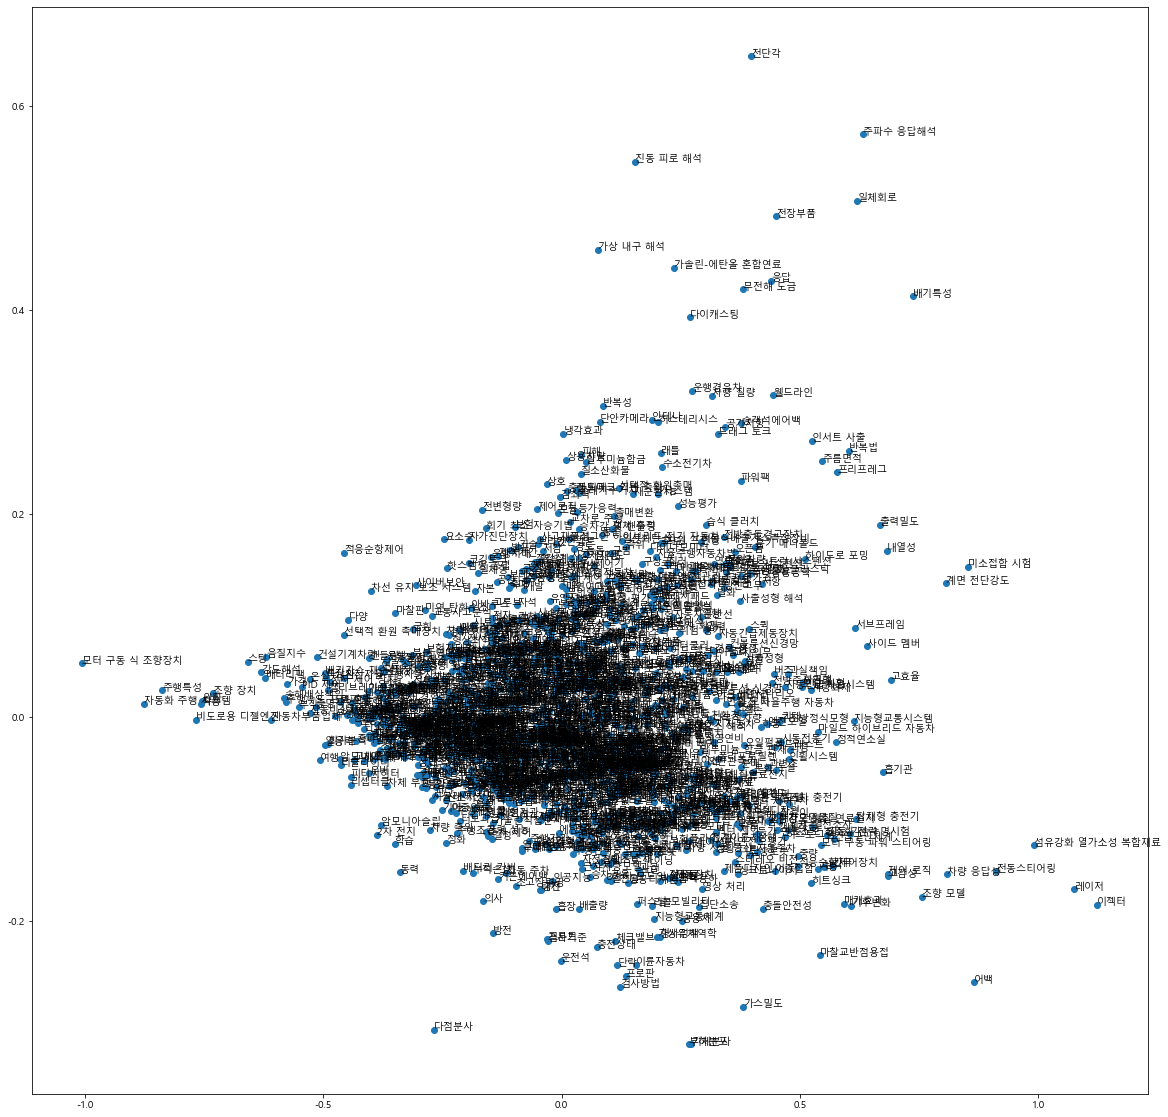

In [14]:
word_vectors = model3.wv

vocabs = word_vectors.vocab.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]

plot_2d_graph(vocabs, xs, ys)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1392 samples in 0.065s...
[t-SNE] Computed neighbors for 1392 samples in 0.757s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1392
[t-SNE] Computed conditional probabilities for sample 1392 / 1392
[t-SNE] Mean sigma: 0.041444
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.312866
[t-SNE] KL divergence after 4750 iterations: 0.816449


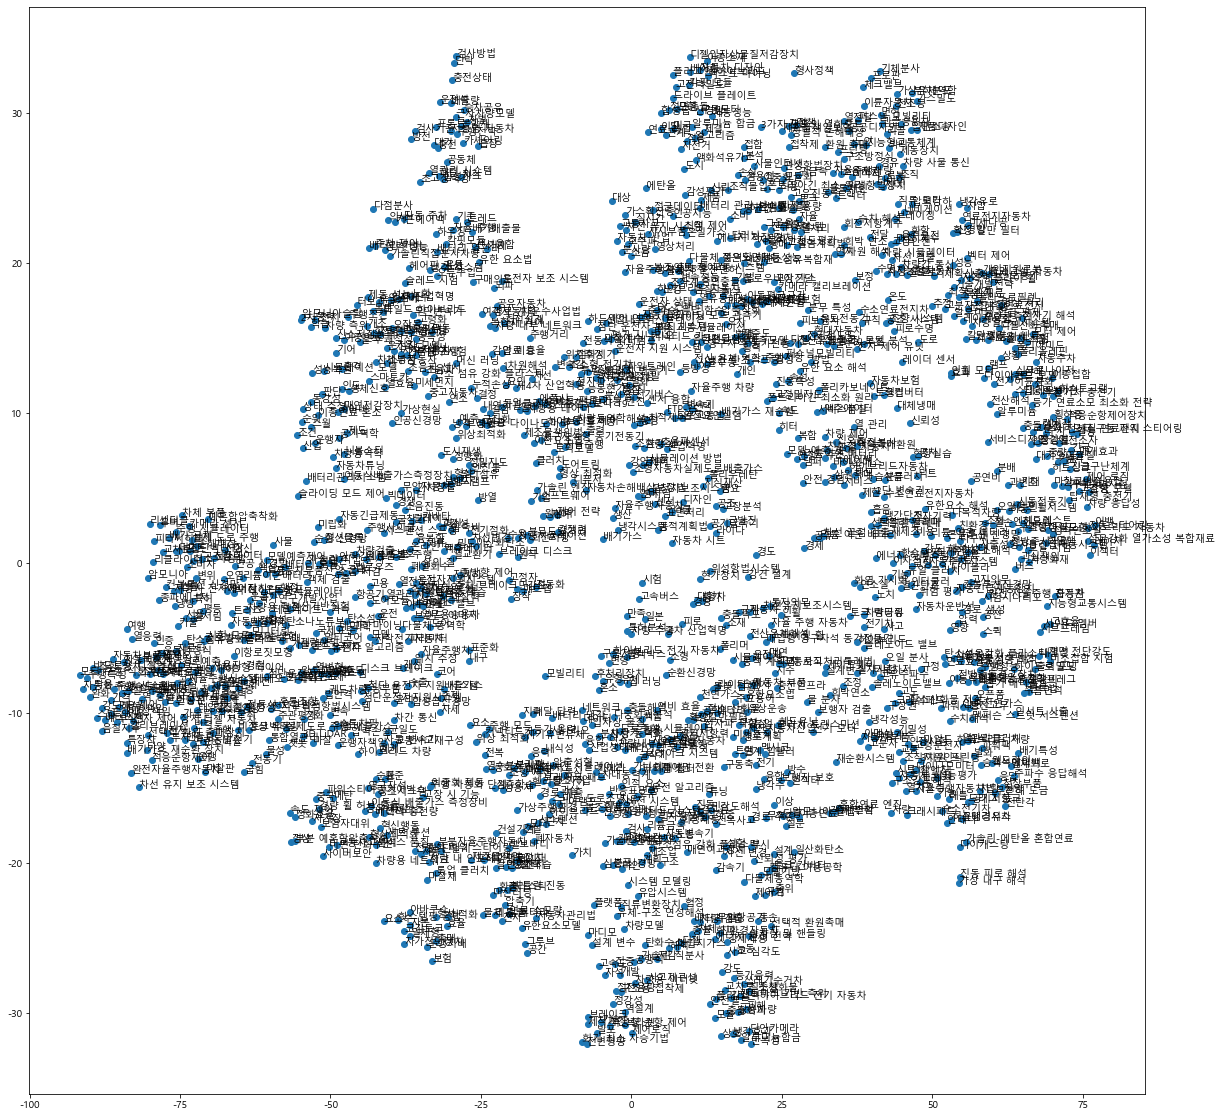

In [15]:
#T-SNE 

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=10000, verbose=1)

#model3(2018-2020-주제어.model) 사용
word_vectors = model3.wv
vocabs = word_vectors.vocab.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]

Z = tsne.fit_transform(word_vectors_list)

plt.figure(figsize=(20, 20))
plt.scatter(Z[:,0], Z[:,1])

#점에 text 붙히기
for i, v in enumerate(vocabs):
    plt.annotate(s=v, xy=(Z[i,0], Z[i,1]))
plt.draw()
plt.savefig('./images/tsne.png', dpi=300)

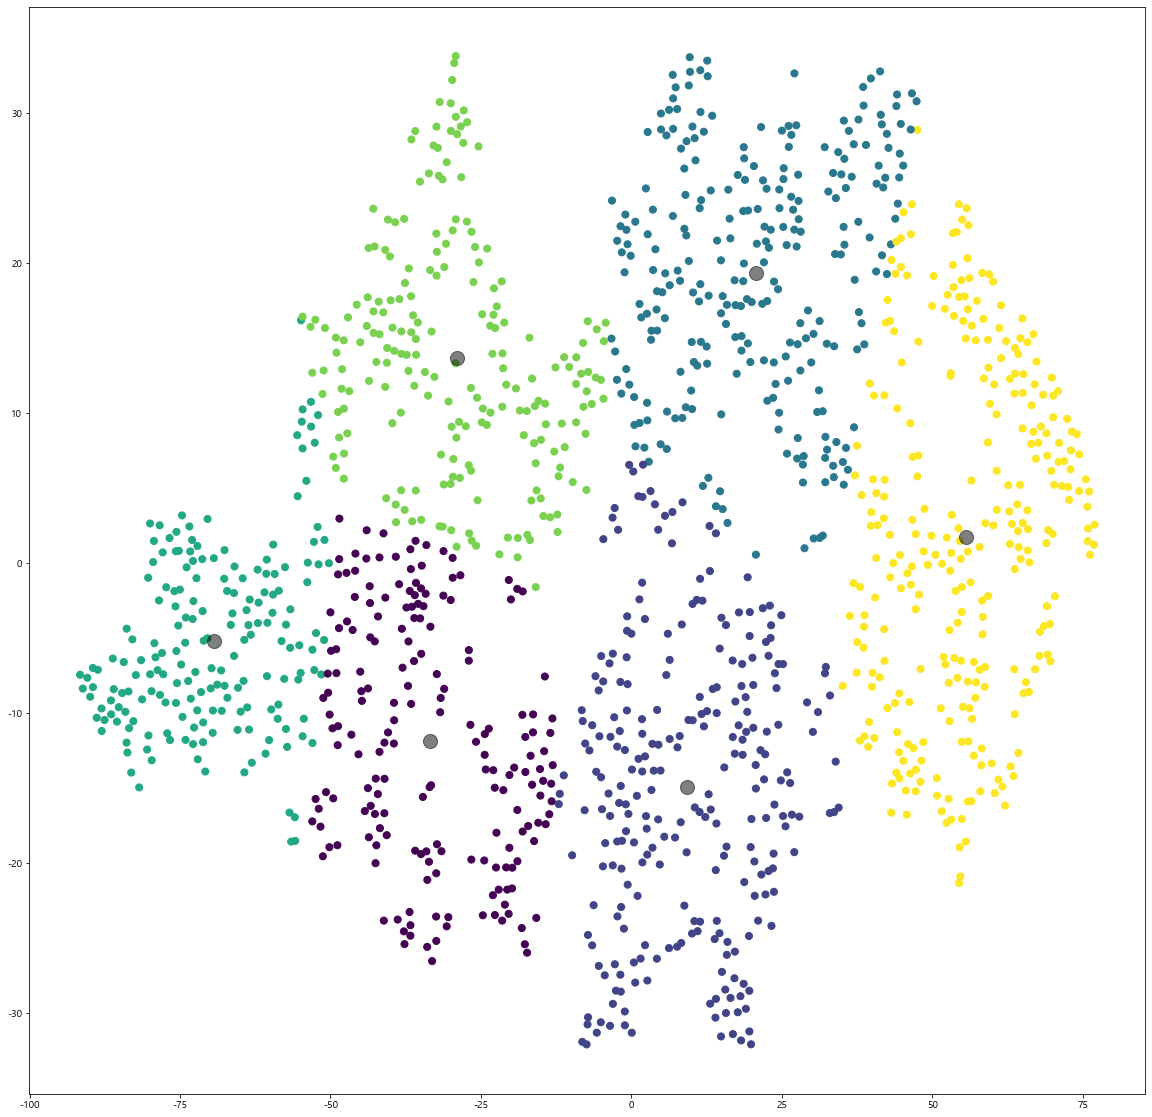

In [16]:
#T-SNE 결과를 K-Means 클러스터링으로 분류
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6).fit(Z)
y_kmeans = kmeans.predict(Z)
centers = kmeans.cluster_centers_

plt.figure(figsize=(20, 20))

plt.scatter(Z[:,0], Z[:,1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.draw()
plt.savefig('./images/kmeans_clustering.png', dpi=300)

#plt.figure(figsize=(20, 20))

In [17]:
del model1
del model2
del model3

### 1. 주제어 추천 및 관련논문 제시

In [18]:
#저장된 모델 로딩
#del model1
model1 = Word2Vec.load("./model/2018-2020-주제어.model")

INFO - 14:51:34: loading Word2Vec object from ./model/2018-2020-주제어.model
INFO - 14:51:35: loading wv recursively from ./model/2018-2020-주제어.model.wv.* with mmap=None
INFO - 14:51:35: setting ignored attribute vectors_norm to None
INFO - 14:51:35: loading vocabulary recursively from ./model/2018-2020-주제어.model.vocabulary.* with mmap=None
INFO - 14:51:35: loading trainables recursively from ./model/2018-2020-주제어.model.trainables.* with mmap=None
INFO - 14:51:35: setting ignored attribute cum_table to None
INFO - 14:51:35: loaded ./model/2018-2020-주제어.model


In [19]:
keyword = "자율주행"

In [20]:
#주제어 추천
def find_keyword(word, model) :
    try :
        result = model.wv.most_similar(keyword, topn=10)
        return [x[0] for x in result]
    except :
        return ('없는 단어 입니다.')
    

In [21]:
#최신순으로 상위 10개의 논문 제시
def find_article(word, model) :
    keywords = find_keyword(word, model)
    data = train_data[train_data['주제어'].notna() & train_data['주제어'].str.contains('|'.join(keywords))].sort_values(by=['발행연도'], axis=0, ascending=False)[:10]
    data = list(data.loc[:, ['제목', '저자']].to_records(index=False))
    
    for i, v in enumerate(data) :
        print(f'{i+1} 번째 논문')
        print(f'\t제목: {v[0]}')
        print(f'\t저자: {v[1].split(",")[0]}')

In [22]:
#주제어 추천
find_keyword(keyword, model1)

INFO - 14:51:35: precomputing L2-norms of word weight vectors


['차압',
 '최적제어',
 '센서 고장',
 '센서 융합',
 '모델 개발',
 '배기가스 재순환',
 '미세다공',
 '변속기',
 '전기버스',
 '시뮬레이션 방법']

In [23]:
#논문 추천
find_article(keyword, model1)

1 번째 논문
	제목: 싱크로나이저 체결 작동력 변화에 따른 싱크로 메커니즘 거동 해석
	저자: 이원호(Wonho Lee)
2 번째 논문
	제목: 레이더 및 라이다 센서융합을 이용한 도로경계 검출
	저자: 유희철(Heecheol Yoo)
3 번째 논문
	제목: 스테인리스강의 염욕질화열처리 후 녹발생 억제
	저자: 정동진(Dongjin Jeong)
4 번째 논문
	제목: 자동변속기용 오일펌프 재제조 공정기술 개발에 관한 연구
	저자: 홍성도(Sungdo Hong)
5 번째 논문
	제목: 센서 융합 기반 전방 차량 인식 성능 평가 연구
	저자: 조하나(Hana Cho)
6 번째 논문
	제목: 압축착화 엔진에서 연료 분사압력, 분사시기 그리고 EGR 비율이 화염 온도와 입자상 물질 농도에 미치는 영향
	저자: 김남호(Namho Kim)
7 번째 논문
	제목: 트랙터용 전 후진 자동변속기의 변속 품질 모사를 위한 시뮬레이션 모델 개발
	저자: 안다빈(Da-Vin Ahn)
8 번째 논문
	제목: 전동화 변속기를 위한 도그 클러치 모델링 및 확률 기반의 적정 체결 조건 해석
	저자: 강주영(Jooyoung Kang)
9 번째 논문
	제목: 자동화 수동 변속기의 브레이크 팩 내부 공간에서의 변속기유 거동 특성 연구
	저자: 박상빈(Sangbin Park)
10 번째 논문
	제목: 중형전기버스용 e-Axle 구동모듈 내구평가 모드 개발에 관한 연구
	저자: 홍은희(Eunhee Hong)


In [24]:
del model1

In [25]:
#년도 그룹별 주제어 로딩
model1 = Word2Vec.load("./model/2012-2014-주제어.model")
model2 = Word2Vec.load("./model/2015-2017-주제어.model")
model3 = Word2Vec.load("./model/2018-2020-주제어.model")

INFO - 14:51:35: loading Word2Vec object from ./model/2012-2014-주제어.model
INFO - 14:51:35: loading wv recursively from ./model/2012-2014-주제어.model.wv.* with mmap=None
INFO - 14:51:35: setting ignored attribute vectors_norm to None
INFO - 14:51:35: loading vocabulary recursively from ./model/2012-2014-주제어.model.vocabulary.* with mmap=None
INFO - 14:51:35: loading trainables recursively from ./model/2012-2014-주제어.model.trainables.* with mmap=None
INFO - 14:51:35: setting ignored attribute cum_table to None
INFO - 14:51:35: loaded ./model/2012-2014-주제어.model
INFO - 14:51:35: loading Word2Vec object from ./model/2015-2017-주제어.model
INFO - 14:51:35: loading wv recursively from ./model/2015-2017-주제어.model.wv.* with mmap=None
INFO - 14:51:35: setting ignored attribute vectors_norm to None
INFO - 14:51:35: loading vocabulary recursively from ./model/2015-2017-주제어.model.vocabulary.* with mmap=None
INFO - 14:51:35: loading trainables recursively from ./model/2015-2017-주제어.model.trainables.* with

In [26]:
word = '자율주행'

print(f"2012년 ~ 2014년: {find_keyword(word, model1)}")
print(f"2015년 ~ 2017년: {find_keyword(word, model2)}")
print(f"2018년 ~ 2020년: {find_keyword(word, model3)}")

INFO - 14:51:35: precomputing L2-norms of word weight vectors
INFO - 14:51:35: precomputing L2-norms of word weight vectors
INFO - 14:51:35: precomputing L2-norms of word weight vectors
2012년 ~ 2014년: ['조향장치', '스케줄링', '피보험이익', '샤프엣지', '마그네슘 합금 판재', '열성능', '교육', '열적성층화', '복합재료', '예혼합압축자기착화엔진']
2015년 ~ 2017년: ['삼원촉매', '플러그인하이브리드', '무역특화지수', '연비', '결정요인', '한국자동차안전도평가', '능동', '전동기', '변속기', '자본']
2018년 ~ 2020년: ['차압', '최적제어', '센서 고장', '센서 융합', '모델 개발', '배기가스 재순환', '미세다공', '변속기', '전기버스', '시뮬레이션 방법']


In [27]:
del model1
del model2
del model3